In [ ]:
# Data originally from https://www.kaggle.com/secareanualin/football-events
# Related analysis at https://www.kaggle.com/gabrielmanfredi/expected-goals-player-analysis

!wget https://jsc370.github.io/events.csv.zip
!unzip events.csv.zip

!wget https://jsc370.github.io/ginf.csv.zip
!unzip ginf.csv.zip

!wget https://jsc370.github.io/dictionary.txt


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import jax.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

In [5]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

In [6]:
# considering data from particular event ( " 1 = Attempt to shot")
shots = events[events.event_type==1]

In [7]:
# one-hot encoding (binary representation of fature values)

data = pd.get_dummies(shots[["is_goal","bodypart","situation"]], columns=['bodypart', 'situation'])
data.columns =  ['is_goal','right_foot', 'left_foot', 'header', 'open_play', 'set_piece', 'corner', 'free_kick']

# **Soccer!**

**Haiyue Yang, Yun Shen, Xin Peng**

The success of any football match lies in the coaches and managers of soccer teams, since they make decisions for selecting players for matches, planning the strategy and instructing players on the pitch and they are responsible for holding the team together. However, the process of selecting players, deciding the best strategy and supporting players based on their own attributes is always very difficult in real life, and it is hard for humans to make objective decisions based on so many attributes. So in this report, we are going to design a decision-support tool that can aid coaches and managers' decision making process and lead to a successful outcome.

We are using the 'Football Events' dataset from Kaggle (https://www.kaggle.com/secareanualin/football-events), which contains 9074 games, 941009 events from soccer leagues: England, Spain, Germany, Italy, France from 2011/2012 season to 2016/2017 season.

And we have explored the data, brainstormed what factors could help improve the decision-support tool, proposed several models, and implemented three variants below.

# Add-on Value of the Data

* Design strategies (location-wise) for players: if we analyze the hottest spots in the game, we may develop a strategy to guide players where to stand during the game
* Help coaches to better understand what’s important in training
* Focus on certain assist methods: some methods are more efficient
* Focus on training certain body parts: which muscle is crucial during practice


# Key Factors to Measure Success

* Winning of the game, which is the ultimate goal
* Saving from unnecessary training: save time and money from things that are less important to the game
* Less injury: players are beneficial from special training to avoid injury
* Model: best accuracy and least running complexity, since our dataset is very imbalanced, so our model is very cost-sensitive and we must take that into account.
* We might also look at F1-score to determine how good our model is, since when the data is so imbalanced that accuracy might not be the only criteria.


# Data Exploration

Here, I want to discover the performance of each player.

In [ ]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'Goals'}, inplace=True)
most_goals = players.sort_values(['Goals'], ascending=False).reset_index(drop=True)
most_goals['rank'] = most_goals.index+1
most_goals = most_goals[['rank', 'player', 'Goals']].head(10)
most_goals['player'] = most_goals['player'].str.title()
most_goals

,rank,player,Goals
0,1,Lionel Messi,205
1,2,Cristiano Ronaldo,198
2,3,Zlatan Ibrahimovic,153
3,4,Robert Lewandowski,124
4,5,Edinson Cavani,121
5,6,Gonzalo Higuain,118
6,7,Pierreemerick Aubameyang,100
7,8,Luis Suarez,96
8,9,Diego Costa,93
9,10,Alexandre Lacazette,88


Table I: Top 10 players with the maximum number of goals.

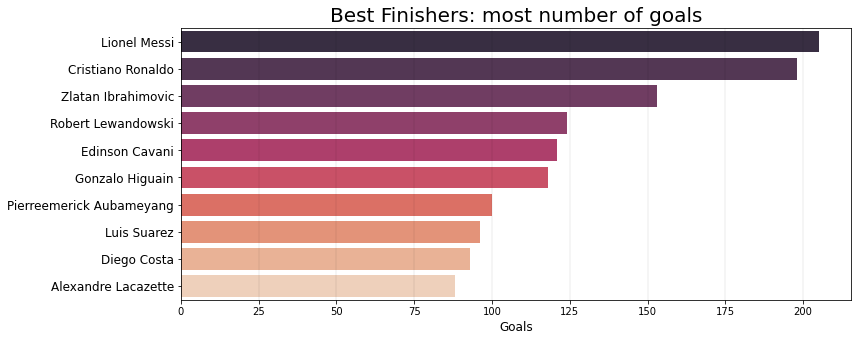

In [ ]:
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(most_goals['Goals']), y=most_goals['player'], palette="rocket", alpha=0.9)
ax.set_xlabel(xlabel='Goals', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most number of goals", fontsize=20)
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()


The result corresponds to our common sense. We see some famous names: Messi, Ronaldo and Ibrahimović are on top of the chart. Messi socres over 200 goals in the league, whereas Ronaldo is slightly below him and scores 198 goals. Besides these two superstars, other top scoring players score around 100 goals.

Next, I will do some analysis on yellow cards and red cards.

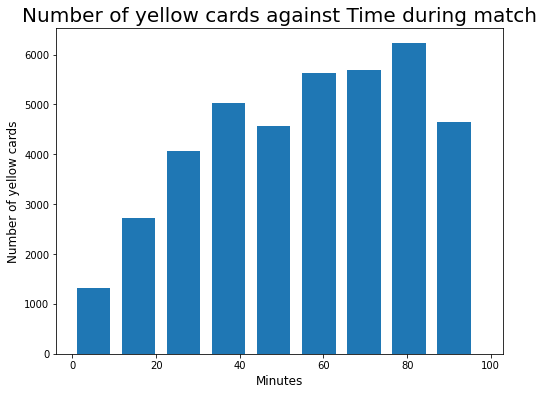

In [ ]:
yellow_card = events[events["event_type"]==4]
plt.figure(figsize=(8,6))
plt.hist(yellow_card.time, width=8, bins=9)   
plt.xlabel("Minutes", fontsize=12)
plt.ylabel("Number of yellow cards", fontsize=12)
plt.title("Number of yellow cards against Time during match", fontsize=20)
plt.show()

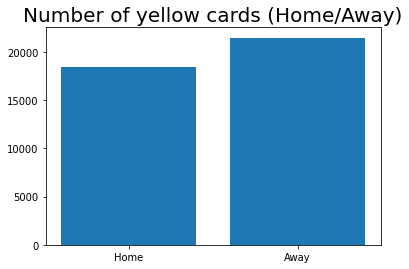

In [ ]:
yellow_home = yellow_card[yellow_card["side"] == 1].shape[0]
yellow_away = yellow_card[yellow_card["side"] == 2].shape[0]
total_yellow = pd.DataFrame({"type": ['Home', 'Away'], "number": [yellow_home, yellow_away]})
plt.bar(total_yellow['type'], total_yellow.number)
plt.title("Number of yellow cards (Home/Away)",fontsize=20)
plt.show()

For yelloe cards, I observe that most of the yellow cards are issued in the second half of the game, especially around 80mins. The reasons might be that players' temper rises as the game moves on and they are more likely to take risky moves to secure the game.

More yellow cards has been issued to the away team compared to the home team.

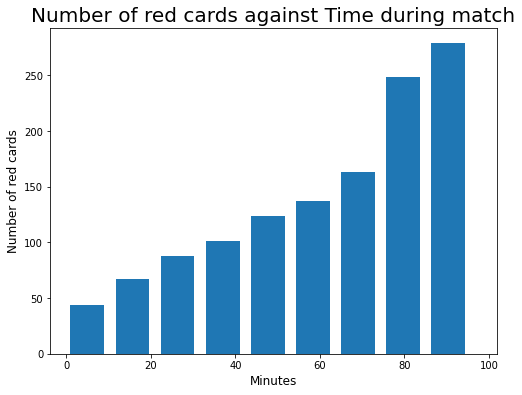

In [ ]:
second_yellow = events[events["event_type"]==5]
red = events[events["event_type"]==6]
reds=[second_yellow,red]
red_cards=pd.concat(reds)
plt.figure(figsize=(8,6))
plt.hist(red_cards.time, width=8, bins=9)   
plt.xlabel("Minutes", fontsize=12)
plt.ylabel("Number of red cards", fontsize=12)
plt.title("Number of red cards against Time during match", fontsize=20)
plt.show()

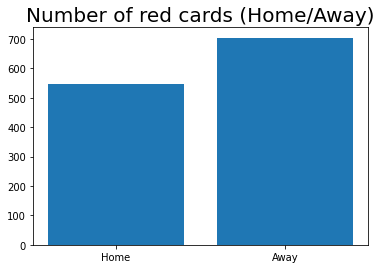

In [ ]:
red_home = red_cards[red_cards["side"] == 1].shape[0]
red_away = red_cards[red_cards["side"] == 2].shape[0]
total_red = pd.DataFrame({"type": ['Home', 'Away'], "number": [red_home, red_away]})
plt.bar(total_red['type'], total_red.number)
plt.title("Number of red cards (Home/Away)",fontsize=20)
plt.show()

For the red cards, there is a clear increasing pattern where the probability of receiving a red card is higher as the game moves through. There is a sharp increase at about 80mins, which id similar to the yellow cards.

Also, more red cards has been issued to the away team compared to the home team. So, I am curious whether the referee has a favour to the home team.

# Brainstorm a comprehensive list of factors that could affect the recorded data.

Before building up a model, it is important to notice that there are many factors that could conceivably influence the recorded data in real life, like the wrong data and many subjective and objective factors that affect whether a shot is a goal. Here are some of these factors:

*   Incorrect data due to using webscraping, integrating and regex, since the author of the dataset webscraped and integrated different data sources, and then used regex to derive data.
*   Missing data when recording, since the author of the dataset said "there are games that have been played during these seasons for which I could not collect detailed data".
*   Incorrect data in the original data sources or websites.
*   Weather condition.
*   Whether the team adapts to the field.
*   Team's injuries.
*   Team's schedules.
*   Team's moltivation.
*   Team's playing strategy.
*   Team's last game outcome, since this will affect player's mental conditions.
*   Synergy or conflict between teammates
*   Psychological aspects like the ability under pressure.
*   Medical conditions of the players.
*   Whether the player is a substitute player or not.
*   Refs bad call or missed call.

# Complementary Sources of Data
Since many factors that are not recoreded in this data can also affect the game outcome, or whether a shot is a goal or not, here are some complementary sources of data that might be useful in providing some extra information.
*   More detailed information about players, e.g., their position, style of play, how many minutes they have played in a specific game, joining time, medical condition.
*   More detailed information about teams, e.g., injuries, schedules.
*   Information about commentaries.
*   Information about some objective conditions, e.g., weather, field.
*   Information about the goalkeeper, e.g., goalkeeper's performance, whether the goalkeeper is facing the attempt.
*   Video recording from multiple positions.
*   Dynamic analysis of the shot.

# Model Staircase

Here are some models we proposed.

*   Logistic regression using "bodypart", "situation" (baseline model).
*   Use mean number of goals by each player assuming the probability that a shot is a goal for each player remains the same.
*   Logistic regression using "side", "location", "bodypart", "assist_method", "situation".
*   Resampling training dataset - undersample majority class (Variant 1 subvariant 1).
*   Resampling training dataset - oversample minority class (Variant 1 subvariant 2).
*   Resampling training dataset - oversample minority class + add prior correction for the bias term (Variant 1 subvariant 3).
*   Change the threshold of baseline logistic regression from 0.5 to some smaller value like 0.2.
*   Use neural network (Variant 2).
*   Use decision tree as the classifier (Variant 2 subvariant).
*   Use random forest as the classifier (Variant 2 subvariant).
*   Use AdaBoost as the classifier (Variant 2 subvariant).
*   Use gradient boosting as the classifier (Variant 2 subvariant).
*   Use KNN as the classifier (Variant 2 subvariant).
*   Add a latent variable for each player and each attempt (Varaint 3).

# Baseline Model(Logistic Regression)

The baseline model uses logistic regression. 

$z = w^Tx+b$

$y = \sigma(z) = \frac{1}{1+e^{-z}}$

And it uses cross entropy loss
$\mathcal{L}_{CE}(y, t) = -tlogy-(1-t)log(1-y)$ and variables 'bodypart' and 'situation'.

And the testing and training data is obtained by simply splitting the original data into random training and testing subsets.

From the result, it seems that the baseline model predicts well since its training accuracy is 89.30707 and testing accuracy is 89.43854. However, from the histogram, we can see that this model simply predicts all observations to be 0, and its $f_1$ score for 'is_goal=1' is 0. 

So in the variants below, we are trying to improve the model performance, decrease loss and increase $f_1$ score for 'is_goal=1'.

In [8]:
# train test split and format data.
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = np.float32(np.array(X_train_data))
X_test = np.float32(np.array(X_test_data))
y_train = np.float32(np.array(y_train_data))
y_test = np.float32(np.array(y_test_data))

c_train = np.ones((X_train.shape[0], 1))               # intercept 
X_train = np.concatenate((c_train, X_train), axis=1)   # Add intercept to the original feature set
c_test = np.ones((X_test.shape[0], 1)) 
X_test = np.concatenate((c_test, X_test), axis=1)


Number of epoch, training loss, training accuracy, testing accuracy using baseline model:



In [9]:
# Simple logistic regression model.

from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.

epochs = 2200
learning_rate = 0.2
test_accuracy_lst1 = []

theta = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

# CE loss
def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y):
  pred = logreg_pred(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 

for i in range(epochs):
  theta = theta - learning_rate * grad(batch_loss)(theta, X_train, y_train)
  if i % 50 == 0:
    loss_tr = batch_loss(theta, X_train, y_train)
    train_loss.append(loss_tr)
    train_accuracy = accuracy(theta, X_train, y_train)
    test_accuracy = accuracy(theta, X_test, y_test)
    test_accuracy_lst1.append(test_accuracy)
    print(i, loss_tr, np.mean(train_accuracy), np.mean(test_accuracy))


[0.39307082 0.2068895  0.12631471 0.05986647 0.34710723 0.00963406
 0.02761745 0.00871211]
0 0.62918705 89.30707 89.43854
50 0.334494 89.30707 89.43854
100 0.3323569 89.30707 89.43854
150 0.3316706 89.30707 89.43854
200 0.3312175 89.30707 89.43854
250 0.33089313 89.30707 89.43854
300 0.33065045 89.30707 89.43854
350 0.33046293 89.30707 89.43854
400 0.3303147 89.30707 89.43854
450 0.33019555 89.30707 89.43854
500 0.33009854 89.30707 89.43854
550 0.3300188 89.30707 89.43854
600 0.32995275 89.30707 89.43854
650 0.32989773 89.30707 89.43854
700 0.3298515 89.30707 89.43854
750 0.3298124 89.30707 89.43854
800 0.32977915 89.30707 89.43854
850 0.3297507 89.30707 89.43854
900 0.32972625 89.30707 89.43854
950 0.329705 89.30707 89.43854
1000 0.32968655 89.30707 89.43854
1050 0.3296703 89.30707 89.43854
1100 0.32965598 89.30707 89.43854
1150 0.3296434 89.30707 89.43854
1200 0.3296321 89.30707 89.43854
1250 0.32962206 89.30707 89.43854
1300 0.329613 89.30707 89.43854
1350 0.32960486 89.30707 89.438

Predictions of testing data using baseline model.

(array([3.8702e+04, 1.0000e+00, 3.0090e+03, 1.7520e+03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3180e+03, 1.0450e+03]),
 array([0.07692171, 0.10258147, 0.12824124, 0.153901  , 0.17956077,
        0.20522052, 0.23088029, 0.25654006, 0.2821998 , 0.30785957,
        0.33351934], dtype=float32),
 <a list of 10 Patch objects>)

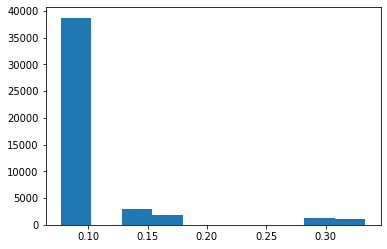

In [10]:
plt.hist(logreg_pred(theta, X_test))

In [11]:
ypred = logreg_pred(theta, X_test)
p = pd.DataFrame(np.around(ypred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     40987
         1.0       0.00      0.00      0.00      4840

    accuracy                           0.89     45827
   macro avg       0.45      0.50      0.47     45827
weighted avg       0.80      0.89      0.84     45827



# Variant 1: Adapt training to handle imbalanced data.
We have already seen that the logistic regression simply predicts all observations to be 0. And this is because we have an imbalanced data.

Text(0, 0.5, '')

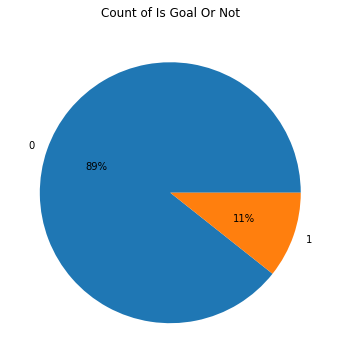

In [ ]:
data['is_goal'].value_counts().plot(kind='pie', figsize=(7, 6), rot=0, autopct='%1.0f%%')
plt.title("Count of Is Goal Or Not", y=1.02)
plt.ylabel("", labelpad=14)

In the original dataset, only 11% of the data is goal, while 89% is not goal, which is quite imbalanced. And this kind of imbalanced data will lead to the accuracy paradox as what we have when using the baseline model.

So in this variant, we have tried several ways to handle imbalanced data, including using resampling techniques, using rare event corrections and changing to algorithms that are robust to imbalanced data.

And in this variant, we are going to variables "side", "location", "bodypart", "assist_method", "situation" to predict instead of only using "bodypart" and "situation", since variables like "side", "location", "assist_method" will also affect if a shot is a goal or not.

## Subvariant 1: Resampling - Undersample majority class.

We used undersampling here to remove some observations of the majority class, i.e., the class where is_goal = 0. So we randomly selected samples where is_goal equals 0 without replacement from the original training data, and 

the number of the samples where is_goal = 0 we selected here = (the number of observations where is_goal = 1 in training data) $\times$ 4.

So in this new training dataset,

number of observations where is_goal is 0 : number of observations where is_goal is 1 = 4 : 1.



In [17]:
# add variables 'side', 'location', 'assist_method'
data = pd.get_dummies(shots[["is_goal", "side", 'location', "bodypart", "assist_method", "situation"]], columns=['side', 'location', 'bodypart', "assist_method", 'situation'])

In [ ]:
# train test split data like usual
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=1)
X_test = np.float32(np.array(X_test_data))
y_test = np.float32(np.array(y_test_data))
c_test = np.ones((X_test.shape[0], 1)) 
X_test = np.concatenate((c_test, X_test), axis=1)

In [ ]:
is_goal_train = y_train_data[y_train_data == 1]
is_goal_train_df = is_goal_train.to_frame()
not_goal_train = y_train_data[y_train_data == 0]
not_goal_train_df = not_goal_train.to_frame()
# randomly select samples where is_goal = 0 to achieve # is goal : # not goal = 1 : 4
not_goal_train = not_goal_train.sample(len(is_goal_train)*4, replace=False)

y_train_data = is_goal_train.append(not_goal_train)
y_train_data = y_train_data.to_frame()

In [ ]:
train_data = y_train_data.join(X_train_data)
X_train_data = train_data.loc[:, train_data.columns != 'is_goal']
y_train_data = train_data[['is_goal']]
y_train_data = y_train_data['is_goal']

In [ ]:
# dataframe to numpy array
X_train = np.float32(np.array(X_train_data))
c_train = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((c_train, X_train), axis=1)
y_train = np.float32(np.array(y_train_data))

Number of epoch, training loss, training accuracy, testing accuracy using variant 1 subvariant 1:

In [ ]:
# Simple logistic regression model(the same as baseline model).

from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.

epochs = 2200
learning_rate = 0.08
test_accuracy_lst2 = []

theta = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

# CE loss
def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y):
  pred = logreg_pred(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 

for i in range(epochs):
  theta = theta - learning_rate * grad(batch_loss)(theta, X_train, y_train)
  loss_tr = batch_loss(theta, X_train, y_train)
  if i % 50 == 0:
    train_loss.append(loss_tr)
    train_accuracy = accuracy(theta, X_train, y_train)
    test_accuracy = accuracy(theta, X_test, y_test)
    test_accuracy_lst2.append(test_accuracy)
    print(i, loss_tr, np.mean(train_accuracy), np.mean(test_accuracy))

[ 0.30000025  0.16434376  0.13565642  0.07129738  0.00280088  0.00364267
  0.00352023  0.02998826  0.00260701  0.02888118  0.00241824 -0.00743839
 -0.00700985  0.16729254  0.00358655  0.00366308  0.00055099 -0.00580072
  0.1565533   0.09849498  0.04495178  0.07145554  0.16247138  0.05354828
  0.00984134  0.00268354  0.2737209   0.00124484  0.01882047  0.00621397]
0 0.6686507 80.0 89.43854
50 0.4742415 80.0 89.43854
100 0.46250963 80.0 89.43854
150 0.45436007 80.0 89.43854
200 0.44780594 80.0 89.43854
250 0.44239628 79.998985 89.43854
300 0.437849 80.08367 89.47346
350 0.43397 80.11734 89.48872
400 0.43062037 81.220345 89.9557
450 0.4276976 81.559105 90.02335
500 0.42512405 81.73358 90.056076
550 0.4228397 81.786644 90.034256
600 0.42079768 81.80297 90.04299
650 0.41896072 82.03867 90.145546
700 0.41729885 82.26519 90.245926
750 0.41578767 82.27947 90.245926
800 0.41440722 82.311104 90.22629
850 0.41314098 82.58559 90.287384
900 0.41197512 82.71006 90.31575
950 0.41089803 82.816185 90.3

Predictions of testing data using variant 1 subvariant 1.

(array([18504., 10310.,  5744.,  7312.,   890.,  1119.,   617.,   625.,
          636.,    70.]),
 array([0.02135868, 0.10370312, 0.18604755, 0.268392  , 0.3507364 ,
        0.43308085, 0.51542526, 0.59776974, 0.68011415, 0.7624586 ,
        0.84480304], dtype=float32),
 <a list of 10 Patch objects>)

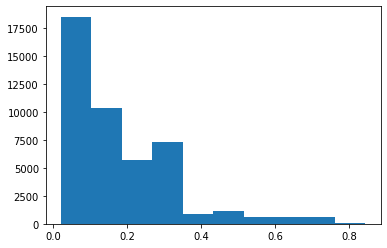

In [ ]:
plt.hist(logreg_pred(theta, X_test))

In [ ]:
ypred = logreg_pred(theta, X_test)
p = pd.DataFrame(np.around(ypred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     40987
         1.0       0.62      0.28      0.38      4840

    accuracy                           0.91     45827
   macro avg       0.77      0.63      0.67     45827
weighted avg       0.89      0.91      0.89     45827



By using undersampling, logistic regression does not predict all observations into a single class anymore, and it predicts some observations to have is_goal=1. And this variant has increased testing accuracy and $f_1$ score for both classes. And we will go back to this result in summary section.

## Subvariant 2: Resampling - Oversample minority class.

Similarly to undersampling, oversampling adds more copies of observations from the minority class, i.e., the class where is_goal = 1. So we randomly selected samples where is_goal equals 1 with replacement from the original training data, and
the number of the samples where is_goal = 1 we selected here = (the number of observations where is_goal = 0 in training data)  /  4.
So in this new training dataset,
number of observations where is_goal is 0 : number of observations where is_goal is 1 = 4 : 1.

In [ ]:
# train test split data like usual
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=1)
X_test = np.float32(np.array(X_test_data))
y_test = np.float32(np.array(y_test_data))
c_test = np.ones((X_test.shape[0], 1)) 
X_test = np.concatenate((c_test, X_test), axis=1)

In [ ]:
is_goal_train = y_train_data[y_train_data == 1]
is_goal_train_df = is_goal_train.to_frame()
not_goal_train = y_train_data[y_train_data == 0]
not_goal_train_df = not_goal_train.to_frame()
# randomly select samples where is_goal = 1 with replacement to achieve # is goal : # not goal = 1 : 4
is_goal_train = is_goal_train.sample(int(len(not_goal_train)/4), replace=True)

y_train_data = is_goal_train.append(not_goal_train)
y_train_data = y_train_data.to_frame()

In [ ]:
train_data = y_train_data.join(X_train_data)
X_train_data = train_data.loc[:, train_data.columns != 'is_goal']
y_train_data = train_data[['is_goal']]
y_train_data = y_train_data['is_goal']

In [ ]:
# dataframe to numpy array
X_train = np.float32(np.array(X_train_data))
c_train = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((c_train, X_train), axis=1)
y_train = np.float32(np.array(y_train_data))

Number of epoch, training loss, training accuracy, testing accuracy using variant 1 subvariant 2:

In [ ]:
# Simple logistic regression model(the same as baseline model).

from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.

epochs = 2200
learning_rate = 0.08
test_accuracy_lst3 = []
iterations = []

theta = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

# CE loss
def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y):
  pred = logreg_pred(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 

for i in range(epochs):
  theta = theta - learning_rate * grad(batch_loss)(theta, X_train, y_train)
  loss_tr = batch_loss(theta, X_train, y_train)
  if i % 50 == 0:
    train_loss.append(loss_tr)
    train_accuracy = accuracy(theta, X_train, y_train)
    test_accuracy = accuracy(theta, X_test, y_test)
    test_accuracy_lst3.append(test_accuracy)
    iterations.append(i)
    print(i, loss_tr, np.mean(train_accuracy), np.mean(test_accuracy))


[ 0.30000287  0.1633778   0.13662507  0.07056778  0.00272439  0.00373107
  0.0036089   0.03021507  0.00262665  0.02832388  0.00258023 -0.00691482
 -0.00706387  0.16754626  0.00365532  0.00376772  0.00047891 -0.00584461
  0.15675619  0.09866442  0.04458226  0.0719972   0.16185313  0.05338093
  0.00985911  0.00291253  0.27445954  0.00059863  0.01881905  0.0061256 ]
0 0.66863245 80.00029 89.43854
50 0.47402453 80.00029 89.43854
100 0.46223047 80.00029 89.43854
150 0.4540596 80.00029 89.43854
200 0.447508 80.00029 89.43854
250 0.4421153 80.00029 89.43854
300 0.43759328 80.043785 89.4669
350 0.43374458 80.8159 89.73094
400 0.43042803 81.24789 89.92951
450 0.42753953 81.54208 90.001526
500 0.4250003 81.73804 90.03644
550 0.42274988 81.791794 90.03644
600 0.4207407 82.041016 90.14773
650 0.41893512 82.048836 90.145546
700 0.41730306 82.25457 90.221924
750 0.41581994 82.2878 90.21537
800 0.41446584 82.33569 90.221924
850 0.4132243 82.449554 90.30921
900 0.4120814 82.613266 90.28302
950 0.41102

Predictions of testing data using variant 1 subvariant 2.

(array([18303., 10523.,  5745.,  7294.,   877.,  1159.,   574.,   646.,
          640.,    66.]),
 array([0.02067448, 0.10308277, 0.18549106, 0.26789936, 0.35030764,
        0.43271592, 0.5151242 , 0.5975325 , 0.6799408 , 0.76234907,
        0.8447574 ], dtype=float32),
 <a list of 10 Patch objects>)

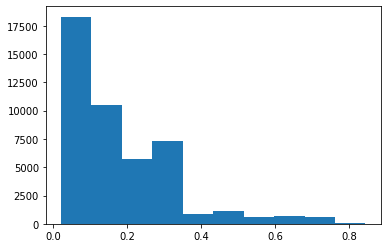

In [ ]:
plt.hist(logreg_pred(theta, X_test))

In [ ]:
ypred = logreg_pred(theta, X_test)
p = pd.DataFrame(np.around(ypred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     40987
         1.0       0.61      0.29      0.39      4840

    accuracy                           0.91     45827
   macro avg       0.76      0.63      0.67     45827
weighted avg       0.89      0.91      0.89     45827



The result we get using this variant is quite similar to the result when using undersampling, since what oversampling does here is almost the same as what undersampling does. And oversampling also increases testing accuracy and $f_1$ score for both classes.

## Subvariant 3: Oversampling + Prior correction for bias term.

Oversampling will not affect the slope estimates, however it will affect the intercept estimate, and any computation based on all parameters are incorrect. Gary King and Langche Zeng have proposed an adjustment of the intercept by computing the usual logistic regression MLE for intercept, and correcting the estimate based on prior information about proportion of ones in the population, and proportion of ones in our sample. 

$\beta_0$ = $\hat{\beta_0}-ln[(\frac{1-\tau}{\tau})(\frac{\bar{y}}{1-\bar{y}})]$, where $\tau$ is the fraction of 1s in the population, and $\bar{y}$ is the fraction of 1s in our sample data (King, G., & Zeng, L. 2001).

In [18]:
# train test split data like usual
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=1)
X_test = np.float32(np.array(X_test_data))
y_test = np.float32(np.array(y_test_data))
c_test = np.ones((X_test.shape[0], 1)) 
X_test = np.concatenate((c_test, X_test), axis=1)

In [19]:
is_goal_train = y_train_data[y_train_data == 1]
is_goal_train_df = is_goal_train.to_frame()
not_goal_train = y_train_data[y_train_data == 0]
not_goal_train_df = not_goal_train.to_frame()
# randomly select samples where is_goal = 1 with replacement to achieve # is goal : # not goal = 1 : 4
is_goal_train = is_goal_train.sample(int(len(not_goal_train)/4), replace=True)

y_train_data = is_goal_train.append(not_goal_train)
y_train_data = y_train_data.to_frame()

In [20]:
train_data = y_train_data.join(X_train_data)
X_train_data = train_data.loc[:, train_data.columns != 'is_goal']
y_train_data = train_data[['is_goal']]
y_train_data = y_train_data['is_goal']

In [21]:
# dataframe to numpy array
X_train = np.float32(np.array(X_train_data))
c_train = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((c_train, X_train), axis=1)
y_train = np.float32(np.array(y_train_data))

Number of epoch, training loss, training accuracy, testing accuracy using variant 1 subvariant 3:

In [22]:
# Simple logistic regression model.
import copy
from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.

# corrected bias = bias - correction_val
# 0.10666637571737185 is fraction of 1s in the population
# 0.2 is fraction of 1s in our sample data
correction_val = np.log((0.8933336242826282/0.10666637571737185)*(0.2/0.8))
epochs = 2200
learning_rate = 0.2
test_accuracy_lst4 = []

theta = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

# prediction using original bias
def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

# prediction using corrected bias
def logreg_pred_adj(params, X):
  return sigmoid(np.dot(X, params)-correction_val)

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

# CE loss
# single loss using original bias
def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

# single loss using corrected bias
def single_loss_adj(params, X, y):
  return -log_bernoulli(y, logreg_pred_adj(params, X))

# batch loss using original bias
def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

# batch loss using corrected bias
def batch_loss_adj(params, X, y):
  vectorized_logprob = vmap(single_loss_adj, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y):
  pred = logreg_pred(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

# accuracy using corrected bias
def accuracy_adj(params, x, y):
  pred = logreg_pred_adj(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 

for i in range(epochs):
  theta = theta - learning_rate * grad(batch_loss)(theta, X_train, y_train)
  loss_tr = batch_loss(theta, X_train, y_train)
  train_loss.append(loss_tr)

  if i % 50 == 0:
    train_accuracy_adj = accuracy_adj(theta, X_train, y_train)
    test_accuracy_adj = accuracy_adj(theta, X_test, y_test)
    loss_tr_adj = batch_loss_adj(theta, X_train, y_train)
    test_accuracy_lst4.append(test_accuracy_adj)
    print(i, loss_tr_adj, np.mean(train_accuracy_adj), np.mean(test_accuracy_adj))

# final corrected parameter estimates
theta = list(theta)
theta[0] -= correction_val
theta = np.array(theta)

[ 0.30000287  0.1641475   0.1358554   0.0709343   0.00269996  0.00384835
  0.00359424  0.03001715  0.0026462   0.02843871  0.00230657 -0.00735952
 -0.00709319  0.1677515   0.00367487  0.00380437  0.00047646 -0.0057371
  0.15693945  0.09849828  0.04456515  0.07189699  0.16249576  0.05303397
  0.00965631  0.00291986  0.27391222  0.00069637  0.01901941  0.00637483]
0 0.51452905 80.00029 89.43854
50 0.49578005 80.00029 89.43854
100 0.47911647 80.00029 89.43854
150 0.46812543 80.00029 89.43854
200 0.46039286 80.00029 89.43854
250 0.45462102 79.9998 89.43854
300 0.4501262 80.08533 89.47346
350 0.44651338 80.10829 89.49091
400 0.44353867 80.13712 89.49964
450 0.44104236 80.17035 89.504005
500 0.43891546 80.940025 89.77022
550 0.43708026 81.38374 89.990616
600 0.43547985 81.446785 90.00371
650 0.43407133 81.706276 90.10409
700 0.43282163 81.88806 90.167366
750 0.43170482 81.89881 90.16955
800 0.43070036 81.93009 90.18482
850 0.42979157 81.93009 90.18482
900 0.4289648 81.93009 90.18482
950 0.42

Predictions of testing data using variant 1 subvariant 3.

(array([28671.,  6848.,  6841.,   608.,   905.,   379.,   232.,   519.,
          767.,    57.]),
 array([0.00914319, 0.08478262, 0.16042206, 0.23606148, 0.3117009 ,
        0.38734034, 0.46297976, 0.5386192 , 0.61425865, 0.6898981 ,
        0.7655375 ], dtype=float32),
 <a list of 10 Patch objects>)

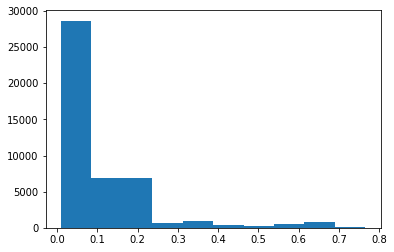

In [ ]:
plt.hist(logreg_pred(theta, X_test))

In [ ]:
ypred = logreg_pred(theta, X_test)
p = pd.DataFrame(np.around(ypred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     40987
         1.0       0.73      0.22      0.34      4840

    accuracy                           0.91     45827
   macro avg       0.82      0.61      0.65     45827
weighted avg       0.90      0.91      0.89     45827



Using oversampling and prior correction for bias term together, we can get 90.90711% testing accuracy, which is 1.64% higher than using the baseline logistic regression, and 0.24% higher than only using oversampling, without using prior correction. And the precision for is_goal=1 is 0.73, which is 12.31% higher than only using oversampling, and recall for is_goal=0 is 0.99, which is also higher than only using oversampling.

## Variant 1 Model Summary and Sanity Check

In variant 1, we are handling the imbalanced data. And the three methods we used here, including undersampling, oversampling, oversampling + prior correction all achieve a better testing accuracy, and a higher $f_1$ score for not goal class. And they all help avoid accuracy paradox, i.e., simply predict all classes to be not goal, so the precision and recall for is goal class also get higher. The summary plot and table for variant 1 are shown below.

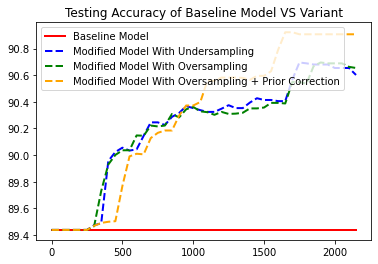

In [ ]:
plt.plot(iterations, test_accuracy_lst1, marker='', color='red', linewidth=2, label="Baseline Model")
plt.plot(iterations, test_accuracy_lst2, marker='', color='blue', linewidth=2, linestyle='dashed', label="Modified Model With Undersampling")
plt.plot(iterations, test_accuracy_lst3, marker='', color='green', linewidth=2, linestyle='dashed', label="Modified Model With Oversampling")
plt.plot(iterations, test_accuracy_lst4, marker='', color='orange', linewidth=2, linestyle='dashed', label="Modified Model With Oversampling + Prior Correction")
plt.title("Testing Accuracy of Baseline Model VS Variant")
plt.legend()
plt.show()

\begin{array}{ccc}
&TrainingLoss&TestingAccuracy&F1Score(NotGoal)&F1Score(IsGoal)&Precision(IsGoal)&Recall(IsGoal)\\
BaselineModel& **0.3295** &89.4385&0.94&0&0&0\\
Undersampling&0.3991&90.6802&0.95&**0.37**&0.65&**0.26**\\
Oversampling&0.3983&90.6889&0.95&**0.37**&0.65&**0.26**\\
Oversampling+PriorCorrection&0.4199&**90.9071**&0.95&0.34&**0.73**&0.22
\end{array}

From the plot and table above, oversampling+prior correction can achieve the highest testing accuracy, which is 90.9071%, and is 1.64% higher than using the baseline model. Also the precision of is_goal=1 is 0.73, which means that for all the shots that are predicted to be goals, 73% of them are predicted correctly. Precision is quite important for coaches to make decisions, since if they are using this decision-support tool to train the players, they will rely on the shots that are predicted to be goals to make strategy and train players. For example, if the decision-support tool predicts that a shot from long distance and using head will be a goal, then coach will train players to shot from long distance and use head. However, this prediction is incorrect, and should not be a goal. And this will become a big decision-making problem. That's why having a higher precision is quite important here, and our new variant has achieved a relatively good precision.

And to do sanity check for this variant, we will take a look at the final prediction for shots from close range and shots from long range using our variant model.

In [23]:
ypred = logreg_pred(theta, X_test)
X_test_data['prediction'] = ypred
X_test_data.columns =  ['home', 'away', 'center_of_box', 'difficult_angle_long_range', 'difficult_angle_left', 'difficult_angle_right', 'left_box', 'left_box_6', 'right_box', 'right_box_6', 'close_range', 'penalty_spot', 'outside_box', 'long_range', '35', '40', 'not_recorded', 'right_foot', 'left_foot', 'header', 'none', 'pass', 'cross', 'headed_pass', 'through_ball', 'open_play', 'set_piece', 'corner', 'free_kick', 'prediction']

In [24]:
X_test_data_close = X_test_data[X_test_data.close_range == 1]
X_test_data_long = X_test_data[X_test_data.long_range == 1]

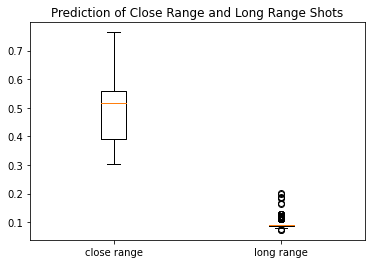

In [25]:
plt.title("Prediction of Close Range and Long Range Shots")
close = X_test_data_close['prediction']
long_range = X_test_data_long['prediction']
plt.boxplot([close, long_range])
plt.xticks([1,2] , ["close range", "long range"])
plt.show()

From the boxplot above, it is very clear that the predictions for shots from close range are closer to 1, and predictions for shots from long range are closer to 0. And this makes sense, since shots from far away are less likely to succeed, and shots that are in close range are more likely to succeed.

## Variant 1 Result and Limitation

In variant 1, the main problem we are dealing with is to handle the imbalanced data, and avoid accuracy paradox. In addition, since we are using resampling to handle the imbalanced data, we also introduce prior correction to correct the bias term that is affected by using resampling. 

And we used undersampling the majority class by removing some observations of the majority class, i.e., the class where is_goal = 0. Similarly, we have also tried oversampling the minority class by adding more copies of observations from the minority class, i.e., the class where is_goal = 1. These two resampling methods help handle imbalanced data by randomly selecting samples to achieve number of observations where is_goal is 0 : number of observations where is_goal is 1 = 4 : 1.

The oversampling+prior correction variant can achieve 90.9071% testing accuracy, which is 1.64% higher than using the baseline model as shown in Section 'Variant 1 Model Summary and Sanity Check'. In addition, its precision for is_goal=1 is 0.73, which is relatively good compared to 0 in baseline logistic regression model.

And 27.52% of the soccer matches end in a draw, so using this variant to support decision-making such as planning strategy and instructing players, it leads to 0.45% more games won compared to using the baseline model.

However, oversampling may cause some problems such as overfitting since it duplicates examples from minority class in the training dataset. So if more shots that are not goal occur, and fewer shots that are goal occur, in other words, if the data becomes more imbalanced, then the risk of getting overfitting will be higher.

# Variant 2: Neural Networks

The second moedel for our model staircase is to build a neural network. While simple models only calculate the distances to predict the classes, complex models such as neural network are more sophisticated and may perform well for the imbalanced data.

For our neural networks, we use Pytorch to simplify the process. Our input is the number of the training data, and our output is a label 0 or 1 to indicate whether it's a goal or miss. Our training data consists of side, location, bodypart, assist_method, situation and fast_break. We have two hidden layers, 16 and 4, resulting from tuning the hyperparameters. Since we are not dealing with imagaes, it's hard to determine the size of the hidden layers as well as the convolution, which  adds each element of an image to its local neighbors, weighted by a kernel, or a small matrix, that helps us extract certain features from the input image. We also use the rectified-linear activation function and sigmoid function over x in our forward function. For our loss function, we use a binary cross entropy loss and an Adam optimizer with a learning rate 0.01. The number of epoch is 2500.



In [ ]:
import pandas as pd
import jax.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

In [ ]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')
# considering data from particular event ( " 1 = Attempt to shot")
shots = events[events.event_type==1]

In [ ]:
data = pd.get_dummies(shots[["is_goal", "side", 'location', "bodypart", "assist_method", "situation", "fast_break"]], \
                      columns=['side', 'location', 'bodypart', "assist_method", 'situation', 'fast_break'])

In [ ]:
# train test split and format data.
import torch
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 16)
    self.fc2 = nn.Linear(16, 4)
    self.fc3 = nn.Linear(4, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(X_train.shape[1])

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
if torch.cuda.is_available():
    print("Using cuda")
    use_cuda = True
    device = torch.device("cuda")
else:
    device = "cpu"
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

net = net.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

Number of epoch, training loss, testing accuracy using variant 2:

In [ ]:
nn_train_loss = []
nn_test_loss = []
nn_train_acc = []
nn_test_acc = []
nn_iterations = []

for epoch in range(2500):
  y_pred = net(X_train)
  y_pred = torch.squeeze(y_pred)

  train_loss = criterion(y_pred, y_train)
  train_acc = calculate_accuracy(y_train, y_pred)

  y_test_pred = net(X_test)
  y_test_pred = torch.squeeze(y_test_pred)
  test_loss = criterion(y_test_pred, y_test)
  test_acc = calculate_accuracy(y_test, y_test_pred)

  if epoch % 50 == 0:
    nn_iterations.append(epoch)
    nn_train_loss.append(train_loss.item())
    nn_train_acc.append(train_acc.item())
    nn_test_loss.append(test_loss.item())
    nn_test_acc.append(test_acc.item())
    print(f'''epoch {epoch} 
    Train set - loss: {train_loss}, accuracy: {train_acc}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

epoch 0 
    Train set - loss: 0.8644660115242004, accuracy: 0.10692932456731796
    Test  set - loss: 0.8648345470428467, accuracy: 0.10561459511518478
    
epoch 50 
    Train set - loss: 0.287494421005249, accuracy: 0.8930706977844238
    Test  set - loss: 0.28471657633781433, accuracy: 0.8943853974342346
    
epoch 100 
    Train set - loss: 0.26673242449760437, accuracy: 0.9059942960739136
    Test  set - loss: 0.26368656754493713, accuracy: 0.9068016409873962
    
epoch 150 
    Train set - loss: 0.26514506340026855, accuracy: 0.9088801145553589
    Test  set - loss: 0.26208066940307617, accuracy: 0.9093111157417297
    
epoch 200 
    Train set - loss: 0.26430007815361023, accuracy: 0.9101893901824951
    Test  set - loss: 0.26131927967071533, accuracy: 0.9106858372688293
    
epoch 250 
    Train set - loss: 0.263606995344162, accuracy: 0.9103421568870544
    Test  set - loss: 0.26069843769073486, accuracy: 0.9107949733734131
    
epoch 300 
    Train set - loss: 0.263018280267

## Model Summary and Sanity Check

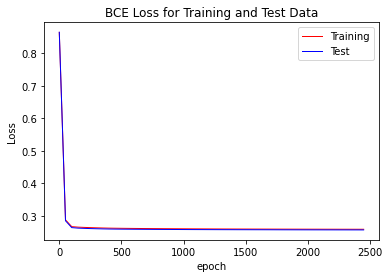

In [ ]:
plt.figure()
plt.plot(nn_iterations, nn_train_loss, marker='', color='red', linewidth=1, label="Training")
plt.plot(nn_iterations, nn_test_loss, marker='', color='blue', linewidth=1, label="Test")
plt.legend()
plt.title('BCE Loss for Training and Test Data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

When we look at the training curve, the BCE loss converges to around 0.25 as epoch number increases. Since we don't see the curev oscillating as epoch number increases, there seems not to have signs of overfitting. Thus, we are happy with our neural networks and we want to verify its performance in terms of accuracy to furthur justify the validity of the model.

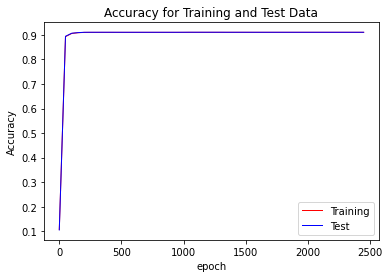

In [ ]:
plt.figure()
plt.plot(nn_iterations, nn_train_acc, marker='', color='red', linewidth=1, label="Training")
plt.plot(nn_iterations, nn_test_acc, marker='', color='blue', linewidth=1, label="Test")
plt.legend()
plt.title('Accuracy for Training and Test Data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

For the training and test accuracy, the result is definitely reasonable. Since our baseline logistic regression model always predict 0s due to the imbalance of the data, it's reasonable to see that in the first 100 epoches our neural network predicts the same result. However, the neural network is able to catch the deep information of our data and starts to predict 1s, increasing both traing and test accuracy to slightly above 90%. The accuracy also converges, so there is no obvious indication of overfitting or underfitting. We are happy with the result so far. 

## Reault and Limitations

Overall, our neural network performs better than the baseline logistic regression model. After both finish training, the loss decreases from 0.3295 to 0.2560. The training accuracy increases from 0.8931 to 0.9107 and the test accuracy increases from 0.8944 to 0.9108. The test accuracy increases by 1.64%.

In [ ]:
y_pred = y_test_pred.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
p = pd.DataFrame(np.around(y_pred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     40987
         1.0       0.71      0.26      0.38      4840

    accuracy                           0.91     45827
   macro avg       0.81      0.62      0.67     45827
weighted avg       0.90      0.91      0.89     45827



When we look at the classification report, we see that the precision for class-0 (miss) increases from 0.89 to 0.92. The precision for class-1 (goal) increases from 0 to 0.71, which is a dramatical increase and the model finally has the ability to predict 1s. The recall for class-1 increases from 0 to 0.26, meaning that the model is finally able to find positive instances. The F1 score for class-1 also increases from 0 to 0.38.

In [ ]:
from sklearn.metrics import roc_auc_score
print('Our neural network obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, y_pred)*100),2))


Our neural network obtains an ROC-AUC of 82%


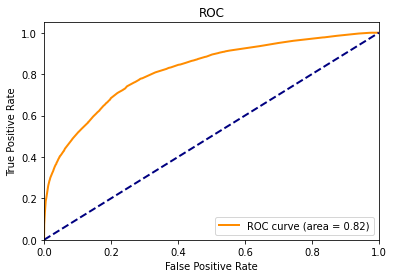

In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('Confusion Matrix:\n')
print(confusion_matrix(y_test, y_pred.round()))


Confusion Matrix:

[[40467   520]
 [ 3569  1271]]


Furthermore, we obtain a pretty good ROC-AUC metric of 82%. This looks very impressing. We also look at the confusion matrix. From all the shots that were missed, our model correctly predicts 40473 as no-goals, and makes a mistake in 3527 cases in which they should be goals. From the other column, we see that it correctly predicts 514 goals, but fails to predict 1268 as goals. This sill reflects that our model is not good enough to predict actual goals. In fact, our model achieves such high accuracy because even predicting all 0s would give an accuracy of 89%.

## Subvaraint: Use of Different Classifiers

In addition of the neural netwrok, I tried to implement multiple classifiers to see whether the result would be better. I used five built-in classifiers from scikit-learn, and they are decision tree, random forest, ada boost, gradient boosting, and KNN.

In [ ]:
X = shots[['bodypart', 'location', 'situation', 'assist_method', 'fast_break']]
y = shots['is_goal']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state=23)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier()]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print(name)
    print("Accuracy: {:.4%}".format(acc))

DecisionTreeClassifier
Accuracy: 91.0729%
RandomForestClassifier
Accuracy: 91.0839%
AdaBoostClassifier
Accuracy: 90.8897%
GradientBoostingClassifier
Accuracy: 91.0555%
KNeighborsClassifier
Accuracy: 90.5776%


We see that the Gradient Boosting Classifier achieves the best result, and it has a test accuracy of 91.06%. I want to discover it further.

In [ ]:
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
print(classification_report(y_test,gbc_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     40939
           1       0.72      0.26      0.38      4888

    accuracy                           0.91     45827
   macro avg       0.82      0.62      0.67     45827
weighted avg       0.90      0.91      0.89     45827



In [ ]:
print('Our Gradient Boosting Classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, gbc_model.
                                                                            predict_proba(X_test)[:, 1])*100),2))

Our Gradient Boosting Classifier obtains an ROC-AUC of 82%


Overall, the performance of the gradient boosting classifier is almost the same as the neural network. They have very similar accuracy, precision, recall, and F1 score. As its name says, it’s a boosting classifier, with many weak models such as decision trees. Gradient Boosting is a sequential process and thus every time it makes an incorrect prediction, it focuses more on that incorrectly predicted data point. In our case, it will focus more on those data which actually scores. With a number of iterations, the correctness will rise.

# Variant 3: Latent Variable Per-Player

The baseline model considered only the `bodypart` and `situation` of shots. In this variant, we add a latent variable for each player in addition to the baseline model. 

There are 3 different `bodypart`: right_foot, left_foot, and header, and 4 different `situation`: open_play, set_piece,	corner, and free_kick, so for simplicity we define the 12 different combinations of `bodypart` and `situation` as a new variable `attempt`, which represents the type of attempt of a shot. And because the sample is imbalanced, with too many shots not goal, we drop the data of player and attempt combinations that never goals. It is not meaningful to predict whether a player is able to goal in a situation that he never goals before.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

In [ ]:
# Import data
events = pd.read_csv('events.csv')
# Considering data from particular event ( " 1 = Attempt to shot")
shots = events[events.event_type==1]

In [ ]:
# For simplicity, convert players to numbers
players = shots['player'].unique()
player_mapping = {}
num_player = len(shots['player'].unique())
for i in range(num_player):
  player_mapping[players[i]] = i
shots['player'] = shots['player'].map(player_mapping)

# For simplicity, define 12 types of attempts based on `bodypart` and `situation`
shots['attempt'] = 10 * shots['bodypart'] + shots['situation']
attempts = shots['attempt'].unique()
attempt_mapping = {}
num_attempt = len(shots['bodypart'].unique()) * len(shots['situation'].unique())
for i in range(num_attempt):
  attempt_mapping[attempts[i]] = i
shots['attempt'] = shots['attempt'].map(attempt_mapping)

In [ ]:
# Drop data of player and attempt combinations that never goal
latent_data = shots[['player', 'attempt', 'is_goal']]
latent_data['id'] = 100 * latent_data['player'] +latent_data['attempt']
ids = latent_data[latent_data['is_goal'] == 1]['id'].unique()
latent_data = latent_data[latent_data['id'].isin(ids)].drop(['id'], axis = 1)

In [ ]:
# Recode the shape of the data
num_player = len(latent_data['player'].unique())
num_attempt = len(latent_data['attempt'].unique())
shape = (num_player, num_attempt)

# Adjust the player and attempt numbers
players = latent_data['player'].unique()
player_mapping = {}
for i in range(num_player):
  player_mapping[players[i]] = i
latent_data['player'] = latent_data['player'].map(player_mapping)

attempts = latent_data['attempt'].unique()
attempt_mapping = {}
for i in range(num_attempt):
  attempt_mapping[attempts[i]] = i
latent_data['attempt'] = latent_data['attempt'].map(attempt_mapping)

After adjusting the dataset, we transform both the training and testing sets into sparse matrices such that each row represents a `player` and each column represents a type of `attempt`. If at least 50% of shots of $player_i$ and $attempt_j$ goal, then the $ij^{th}$ entry of the sparse matrix is 1; otherwise, the $ij^{th}$ entry of the sparse matrix is 0.

In [ ]:
# Randomly split the training and testing set
np.random.seed(2)
order = np.random.permutation(len(latent_data))
latent_data = latent_data.take(order)
cutoff = round(len(latent_data) / 5)
test_data = latent_data[:cutoff]
train_data = latent_data[cutoff:]

In [ ]:
# Convert the datasets to sparse matrix
def sparse_matrix(latent_data, shape):
  sparse_matrix = np.nan * np.empty(shape)
  grouped_data = latent_data.groupby(['player', 'attempt']).mean().reset_index()
  for i in range(len(grouped_data)):
    u = grouped_data['player'][i]
    q = grouped_data['attempt'][i]
    sparse_matrix[u, q] = round(grouped_data['is_goal'][i])
  return sparse_matrix

test_matrix = sparse_matrix(test_data, shape)
train_matrix = sparse_matrix(train_data, shape)

## IRT Model

In this variant, we implemented an Item-Response Theory (IRT) model to predict player's goal rates. The IRT model assigns each player an ability value and each attempt a difficulty value to formulate a probability distribution. In the one-parameter IRT model, $\beta_j$ represents the difficulty of the attempt j, and $\theta_i$ represents the ability of student i. Then, the probability that the shots of player i and attempt j could goal is formulated as:
$$p(c_{ij}=1|\theta_i, \beta_j) = \frac{exp(\theta_i-\beta_j)}{1+exp(\theta_i-\beta_j)}$$



In [ ]:
# The IRT Model
def sigmoid(x):
  return np.exp(x) / (1 + np.exp(x))


def neg_log_likelihood(data, theta, beta):
  diff = theta.reshape((data.shape[0], 1)) - beta.reshape((1, data.shape[1]))
  m = np.multiply(data, diff) - np.log(1 + np.exp(diff))
  m[np.isnan(m)] = 0
  log_lklihood = np.sum(m)
  return -log_lklihood

def update_theta_beta(data, lr, theta, beta):
  diff = theta.reshape((data.shape[0], 1)) - beta.reshape((1, data.shape[1]))
  # gradient descent of theta
  m1 = data - sigmoid(diff)
  m1[np.isnan(m1)] = 0
  d1 = np.sum(m1, axis=1)
  theta = theta + lr * d1
  # gradient descent of beta
  m2 = -data + sigmoid(diff)
  m2[np.isnan(m2)] = 0
  d2 = np.sum(m2, axis=0)
  beta = beta + lr * d2
  return theta, beta

def evaluate(data, theta, beta):
  preds = []
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      target = data[i,j]
      if target == 0 or target == 1:
        pred = round(sigmoid((theta[i] - beta[j]).sum()))
        if pred == 0:
          continue
        preds.append(pred == target)
  return sum(preds) / len(preds)

def evaluate_all(data, theta, beta):
  preds = []
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      target = data[i,j]
      if target == 0 or target == 1:
        pred = round(sigmoid((theta[i] - beta[j]).sum()))
        preds.append(pred == target)
  return sum(preds) / len(preds)


def irt(data, val_data, lr, iterations):
  theta = np.zeros(data.shape[0])
  beta = np.zeros(data.shape[1])

  # list to stored values
  train_nllk_lst = []
  valid_nllk_lst = []

  for i in range(iterations):
      # log-likelihood of training set
      train_neg_lld = neg_log_likelihood(data, theta=theta, beta=beta)
      train_nllk_lst.append(-train_neg_lld)
      # log-likelihood of testing set
      valid_neg_lld = neg_log_likelihood(val_data, theta=theta, beta=beta)
      valid_nllk_lst.append(-valid_neg_lld)
      print("train_nllk: {} \t test_nllk: {}".format(train_neg_lld, valid_neg_lld))
      # update parameters
      theta, beta = update_theta_beta(data, lr, theta, beta)

  # TODO: You may change the return values to achieve what you want.
  return theta, beta, train_nllk_lst, valid_nllk_lst

In [ ]:
iterations = 100
theta, beta, train_nllk_lst, valid_nllk_lst = irt(train_matrix, test_matrix, 0.0005, iterations)
  

train_nllk: 5826.5951997869 	 test_nllk: 4346.725969291417
train_nllk: 5023.893795284591 	 test_nllk: 3657.761924299098
train_nllk: 4533.658399805418 	 test_nllk: 3243.485177569156
train_nllk: 4212.261962079653 	 test_nllk: 2976.474630353644
train_nllk: 3987.9316286411417 	 test_nllk: 2793.295392899025
train_nllk: 3823.638972926018 	 test_nllk: 2661.40469200411
train_nllk: 3698.8432292855796 	 test_nllk: 2562.8758383880686
train_nllk: 3601.3331722222442 	 test_nllk: 2487.134938314903
train_nllk: 3523.415731230749 	 test_nllk: 2427.5756149454587
train_nllk: 3460.009164087826 	 test_nllk: 2379.87096819181
train_nllk: 3407.624175572745 	 test_nllk: 2341.0752846236646
train_nllk: 3363.7871428427316 	 test_nllk: 2309.117909256505
train_nllk: 3326.6970718953103 	 test_nllk: 2282.503758051289
train_nllk: 3295.0127919478127 	 test_nllk: 2260.128534170584
train_nllk: 3267.7161027982897 	 test_nllk: 2241.160557162045
train_nllk: 3244.020998716411 	 test_nllk: 2224.9628218565103
train_nllk: 3223.

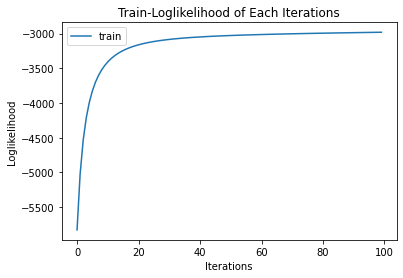

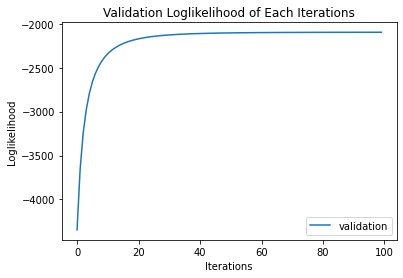

In [ ]:
# plot the log-likelihood curve
plt.figure()
plt.title("Train-Loglikelihood of Each Iterations")
plt.ylabel("Loglikelihood")
plt.xlabel("Iterations")
plt.plot(range(iterations), train_nllk_lst, label='train')
plt.legend()
plt.show()

plt.figure()
plt.title("Validation Loglikelihood of Each Iterations")
plt.ylabel("Loglikelihood")
plt.xlabel("Iterations")
plt.plot(range(iterations), valid_nllk_lst, label='validation')
plt.legend()
plt.show()

## Variant 3 Model Summary and Sanity Check

Because of the imbalanced data, even though the baseline model predicting all shots to not goal had a very high accuracy(89%), it is not meaningful. Therefore, in this variant, we decided to change the measure of success to the accuracy of correctly predicting goals.

There are four outcomes: 

- (0, 0): target = 0 and predict = 0
- (0, 1): target = 0 and predict = 1
- (1, 0): target = 1 and predict = 0
- (1, 1): target = 1 and predict = 1

The original accuracy is defined as:
$$acc = \frac{\#(0,0)+\#(1,1)}{\#(0,0)+\#(0,1)+\#(1,0)+\#(1,1)}$$

Now, the adjusted accuracy is defined as:
$$acc_{adj} = \frac{\#(1,1)}{\#(0,1)+\#(1,1)}$$

Because the baseline model predicts all shots to not goal, even though $acc$ is high, the adjusted accuracy $acc_{adj}=0$.

In [ ]:
train_acc = evaluate(train_matrix, theta, beta)
test_acc = evaluate(test_matrix, theta, beta)
train_acc_all = evaluate_all(train_matrix, theta, beta)
test_acc_all = evaluate_all(test_matrix, theta, beta)
print("Training Accuracy:", train_acc, train_acc_all)
print("Test Accuracy:", test_acc, test_acc_all)

Training Accuracy: 0.5456204379562044 0.839043540328337
Test Accuracy: 0.5165441176470589 0.8591931111465476


\begin{array}{ccc}
&TrainingAccuracy&TestingAccuracy&AdjustedTrainingAccuracy&AdjustedTestingAccuracy\\
BaselineModel& 89.30707 & 89.43854&0&0\\
Variant3&83.42202&85.33858&54.56204&51.65411\\
\end{array}

From the table above, both the adjusted training accuracy and the adjusted testing accuracy is higher than the baseline model. However, the overall accuracy is slightly lower than the baseline model, because although the varaint avoids more type 2 error than the baseline model, it also causes some type 1 error.

Therefore, this variant model works better for shots that successfully goal, but works worse for shots that not goal.

## Result and Limitation

- This variant model is able to predict whether a `player` could goal with a given `bodypart` and in a given `situation`.

- The training and testing set is randomly splitted as in the baseline model. 

- The adjusted accuracy of both the training and testing sets are 50% higher than the baseline model. Because we know only 11% of shots successfully goal, the adjusted accuracy of a random guess of goal is around 11. Therefore, the outcome of the varaint is also around 40% better than a random guess. Even though the overall accuracy of simply predicting all shots to not goal is slightly higher than this model, it is not meaningful to do such a prediction.

- If the model predicts a shot to goal, the accuracy of the prediction is more than 50%. Therefore, if the coach wants to ensure a goal in some given situations, he could make decisions based on this model. For instance, when the coach is deciding the strategy of a free-kick, he could choose a player to shot with the body part such that the model predicts that it would goal. In this situation, more than 50% of chances the free-kick could goal and earn a point for the team.

- However, because the model depends on player latents and the player latents are trained based on a player's previous shots data, many new players with few data avaliable would hurt the accuracy.